# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Đinh Vũ Gia Hân
- MSSV: 22127098
- Lớp: 22CLC08

# Import

In [2]:
import pandas as pd                 # Thư viện xử lý dữ liệu dạng bảng
import numpy as np                  # Thư viện xử lý dữ liệu dạng ma trận

# Import thêm dữ thư viện nếu cần
import matplotlib.pyplot as plt     # Thư viện vẽ đồ thị
import seaborn as sns               # Thư viện vẽ đồ thị
import warnings                     # Thư viện bỏ qua các cảnh báo
warnings.filterwarnings('ignore')   # Phớt lờ mọi cảnh báo

# Đọc dữ liệu

In [3]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [4]:
# Cài đặt các hàm cần thiết ở đây
def preprocess(x, features):
    '''
    Hàm này thực hiện tiền xử lý dữ liệu đầu vào x. Nó dùng để thêm một cột giá trị 1 vào dữ liệu x.

    Tham số
    ----------
    x : pd.trainFrame
        Đầu vào cần được xử lý
    features : list
        Danh sách các tên cột

    Kết quả trả về
    ----------
    X : pd.DataFrame
        Dữ liệu sau khi được xử lý
    '''
    # Thêm cột 1 vào dữ liệu
    data = np.hstack((np.ones((x.shape[0], 1)), x))

    # Tạo tên cột mới
    col_names = ['bias'] + features

    # Chuyển dữ liệu thành DataFrame
    X = pd.DataFrame(data, columns = col_names)

    return X

class OLSLinearRegression:
    def fit(self, X, y):
        '''
        Hàm này được sử dụng để huấn luyện mô hình trên dữ liệu. Hàm sử dụng phương pháp Ordinary Least Squares để tìm ra các tham số tối ưu.

        Tham số
        ----------
        X : pd.DataFrame
            Dữ liệu đầu vào
        y : pd.Series
            Giá trị mục tiêu

        Kết quả trả về
        ----------
        self : object
            Trả về chính object hiện tại
        '''
        # Chuyển dữ liệu thành numpy array
        X_np = X.to_numpy() 
        y_np = y.to_numpy()
        
        # Huấn luyện mô hình
        X_pinv = np.linalg.pinv(X_np.T @ X_np) @ X_np.T
        self.w = X_pinv @ y_np

        return self
    
    def get_params(self):
        '''
        Hàm này trả về các tham số của mô hình

        Kết quả trả về
        ----------
        self.w : np.array
            Trọg số của mô hình (vector cột)
        '''
        return self.w
    
    def predict(self, X):
        '''
        Hàm dự đoán giá trị mục tiêu dựa trên dữ liệu đầu vào

        Tham số
        ----------
        X : np.DataFrame
            Dữ liệu đầu vào

        Kết quả trả về
        ----------
        y_hat : pd.Series
            Giá trị mục tiêu dự đoán
        '''
        # Chuyển dữ liệu thành numpy array
        X_np = X.to_numpy()
        
        # Tính giá trị dự đoán
        y_hat = X_np @ self.w
        
        return pd.Series(y_hat, index = X.index)
    
def MAE(y, y_hat):
    '''
    Hàm tính độ đo Mean Absolute Error (MAE) 

    Tham số
    ----------
    y : Series
        Giá trị thực tế
    y_hat : Series
        Giá trị dự đoán

    Kết quả trả về
    ----------
    np.mean(np.abs(np.array(y) - np.array(y_hat))) : float
        Mean Absolute Error giữa y và y_hat
    '''
    return np.mean(np.abs(np.array(y) - np.array(y_hat)))

class KFoldsCrossValidation:
    def __init__(self, k, features, models, data):
        '''
        Hàm khởi tạo của lớp KFoldsCrossValidation

        Tham số
        ----------
        k : int
            Số lượng fold
        features : list
            Danh sách các đặc trưng
        models : list
            Danh sách các mô hình
        data : pd.DataFrame
            Dữ liệu cần thực hiện cross validation
        '''
        self.k = k
        self.features = features
        self.models = models
        self.data = data
        
    def shuffle_data(self):
        '''
        Xáo trộn dữ liệu trước khi split
        '''
        # Đặt seed để mỗi lần chạy sẽ sinh ra kết quả giống nhau
        np.random.seed(42)

        # Xáo trộn dữ liệu
        data_arr = self.data.values
        np.random.shuffle(data_arr)

        # Chuyển dữ liệu đã xáo trộn thành DataFrame
        self.data_shuffled = pd.DataFrame(data_arr, columns = self.data.columns) 
        
    def split_to_k_folds(self):
        '''
        Chia dữ liệu đã được xáo trộn thành k fold bằng nhau
        '''
        # Tính sô dòng của dữ liệu
        rows = self.data_shuffled.shape[0]

        # Chia dữ liệu thành k fold
        self.folds = [self.data_shuffled.iloc[i * (rows // self.k): (i + 1) * (rows // self.k)].reset_index(drop=True) for i in range(self.k)]
        
    def cross_validation(self):
        '''
        Thực hiện cross validation trên các mô hình và đặc trưng đã cho
        '''
        self.avg_maes_list = []  # Lưu giá trị MAE trung bình của mỗi model

        for model in self.models:
            mae_list = []  # Lưu giá trị MAE của mỗi fold
            for fold in self.folds:
                # Tách tập test
                X_test_i = fold.loc[:, model]
                y_test_i = fold.iloc[:, -1]

                # Tạo tập train bằng cách loại bỏ fold hiện tại
                train_fold = self.data_shuffled.drop(fold.index)
                X_train_i = train_fold.loc[:, model]
                y_train_i = train_fold.iloc[:, -1]

                # Huấn luyện mô hình trên tập train
                lr = OLSLinearRegression().fit(X_train_i, y_train_i)

                # Dự đoán trên tập test
                y_hat_i = lr.predict(X_test_i)

                # Tính MAE cho fold hiện tại
                mae_i = MAE(y_test_i, y_hat_i)
                mae_list.append(mae_i)

            # Tính MAE trung bình cho model hiện tại trên tất cả các fold
            mae_mean = np.mean(mae_list)
            self.avg_maes_list.append(mae_mean)

    def best_model(self):
        '''
        Trả về danh sách giá trị MAE trung bình của mỗi model và chỉ số của model có MAE trung bình nhỏ nhất

        Kết quả trả về
        ----------
        self.avg_maes_list : list
            Danh sách chứa giá trị MAE trung bình của mỗi model
        best_model_index : int
            Index của model có MAE trung bình nhỏ nhất
        '''
        # Tìm chỉ số của đặc trưng có MAE trung bình nhỏ nhất
        best_model_index = np.argmin(self.avg_maes_list)
        return self.avg_maes_list, best_model_index

*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu (1 điểm)

### Mô tả dữ liệu
- Hours Studied: Tổng số giờ học của mỗi sinh viên.          
- Previous Scores: Điểm số học sinh đạt được trong các bài kiểm tra trước đó.
- Extracurricular Activities: Sinh viên có tham gia hoạt động ngoại khóa không (Có hoặc Không).
- Sleep Hours: Số giờ ngủ trung bình mỗi ngày của sinh viên.
- Sample Question Papers Practiced: Số bài kiểm tra mẫu mà học sinh đã luyện tập.
- Performance Index: Thước đó thành tích tổng thể cho mỗi sinh viên. 

### Mục tiêu
Performance Index: Thước đó thành tích tổng thể cho mỗi sinh viên. Chỉ số thể hiện thành tích học tập, nằm trong đoạn [10, 100]. Chỉ số này tỉ lệ thuận với thành tích.

### Khám phá dữ liệu

In [5]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9000 non-null   int64  
 1   Previous Scores                   9000 non-null   int64  
 2   Extracurricular Activities        9000 non-null   int64  
 3   Sleep Hours                       9000 non-null   int64  
 4   Sample Question Papers Practiced  9000 non-null   int64  
 5   Performance Index                 9000 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 422.0 KB


In [6]:
train.duplicated().sum()

103

In [7]:
train.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [8]:
train.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4.976444,69.396111,0.493667,6.535556,4.590889,55.136333
std,2.594647,17.369957,0.499988,1.695533,2.864570,19.187669
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,70.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


### Phân tích dữ liệu
- Dữ liệu gồm 9000 dòng và 6 cột.
- Dữ liệu gồm toàn các giá trị dưới dạng số. Trong đó 5 loại dữ liệu dạng số nguyên và 1 loại dữ liệu dạng số thực.
- Dữ liệu không có giá null nào.
- Có 103 giá trị giống nhau.
- Số giờ học trung bình của một sinh viên xấp xỉ 5 tiếng.
- Điểm số trước đó trung bình rơi vào khoảng 69 điểm, điểm thấp nhất là 40 điểm và không có sinh viên đạt điểm tuyệt đối.
- Số sinh viên tham gia và không tham gia hoạt động ngoại khóa gần như cân bằng.
- Trung bình một sinh viên ngủ 6 tiếng rưỡi một ngày, khá ít so với một giấc ngủ tiêu chuẩn.
- Số bài tập một sinh viên trung từ 4 đến 5 bài (4.59).
- Thành tích học tập trung bình của sinh viên là khoảng 55 điểm. 

### Trực quan hóa dữ liệu

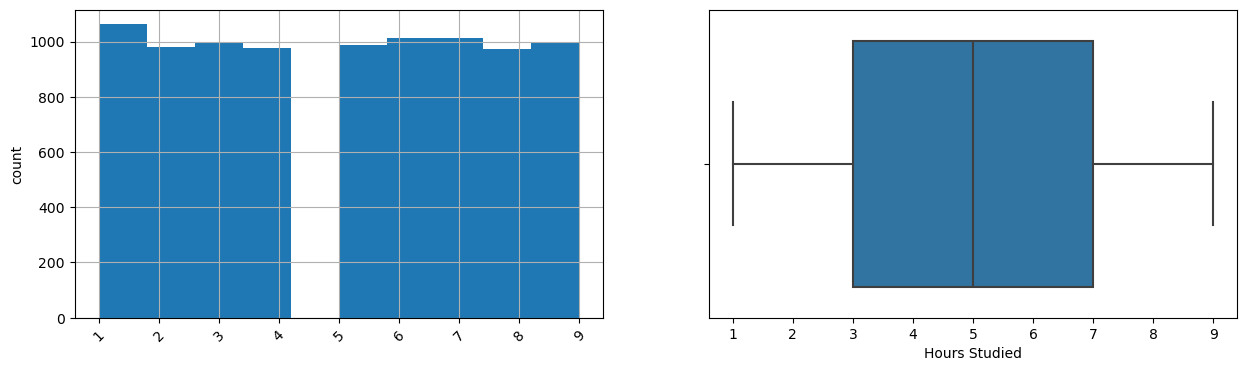

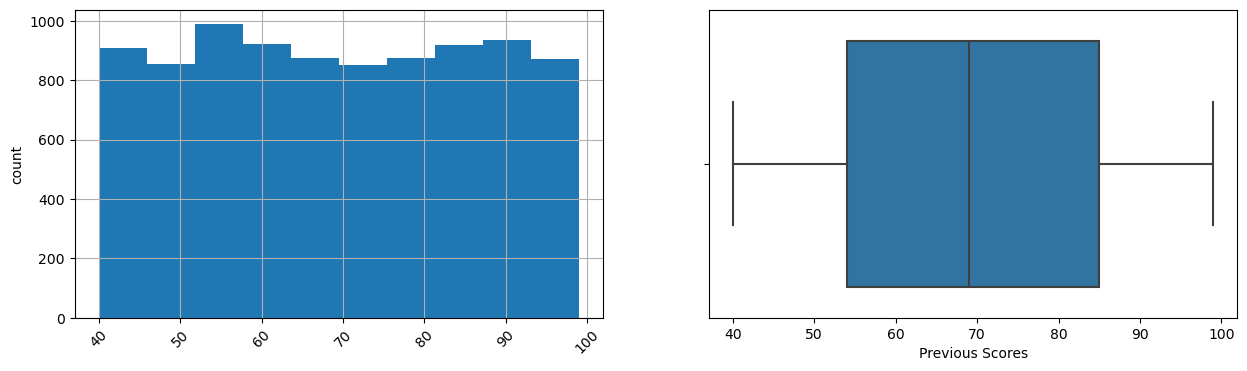

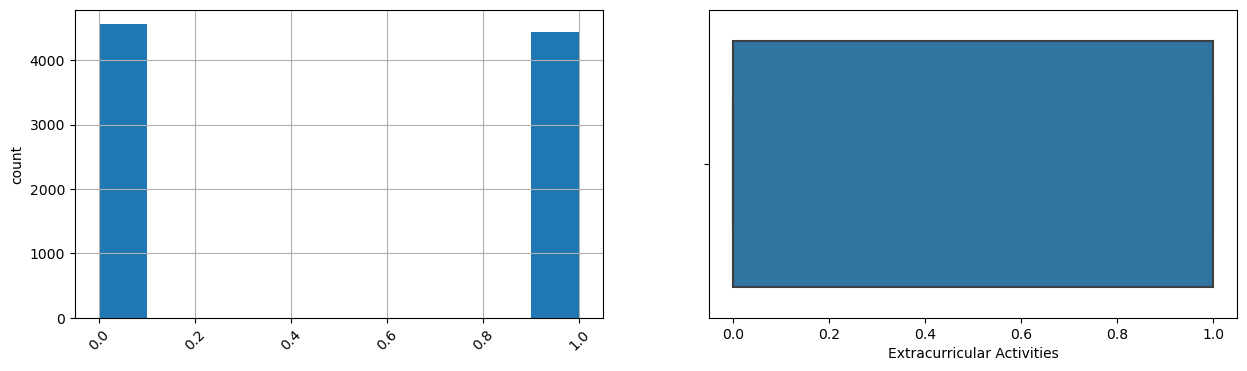

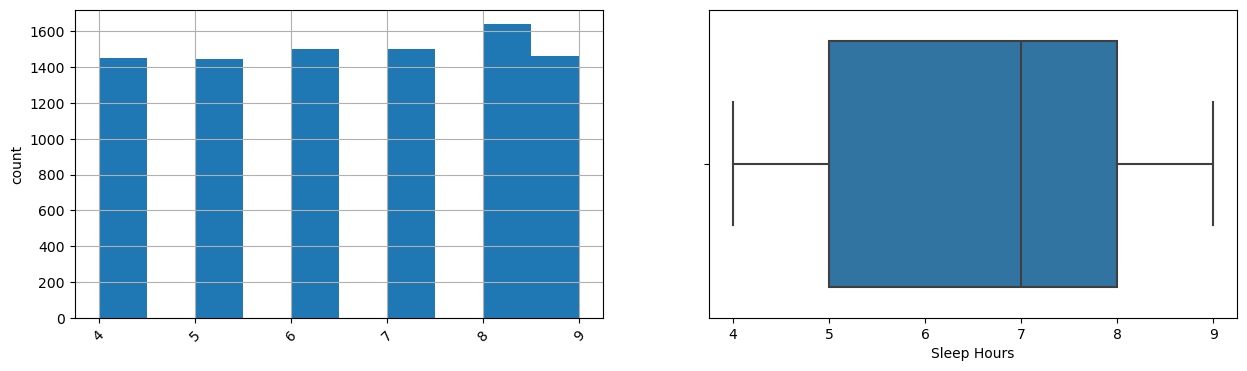

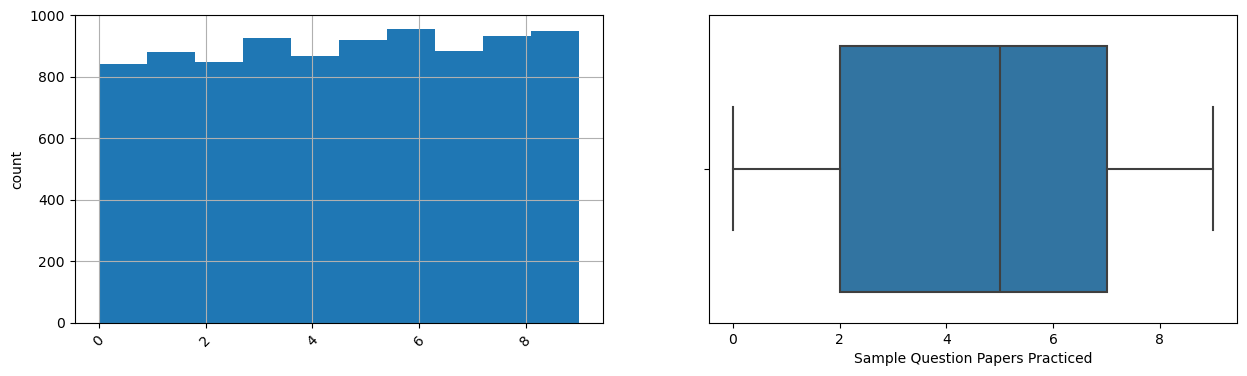

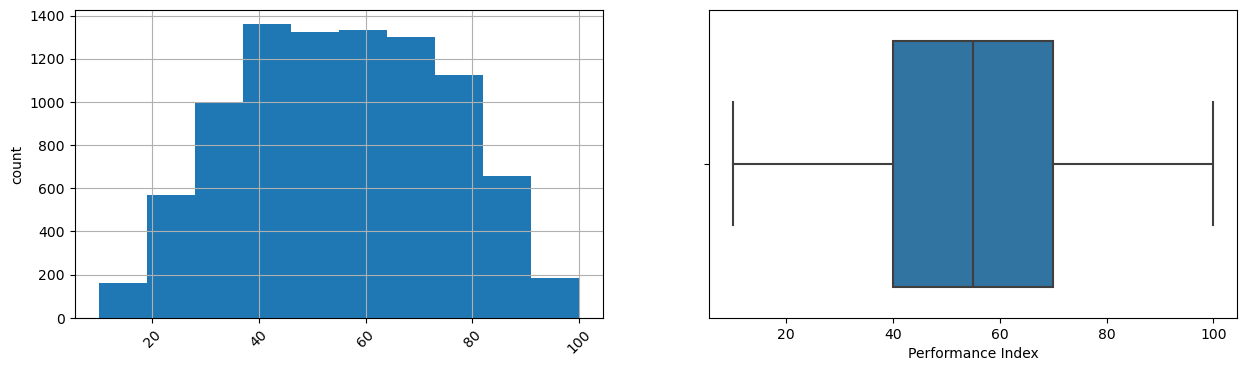

In [9]:
for col in train.columns:
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    train[col].hist(figsize = (15, 4), xrot = 45, bins = 10)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x = train[col])
    plt.show()

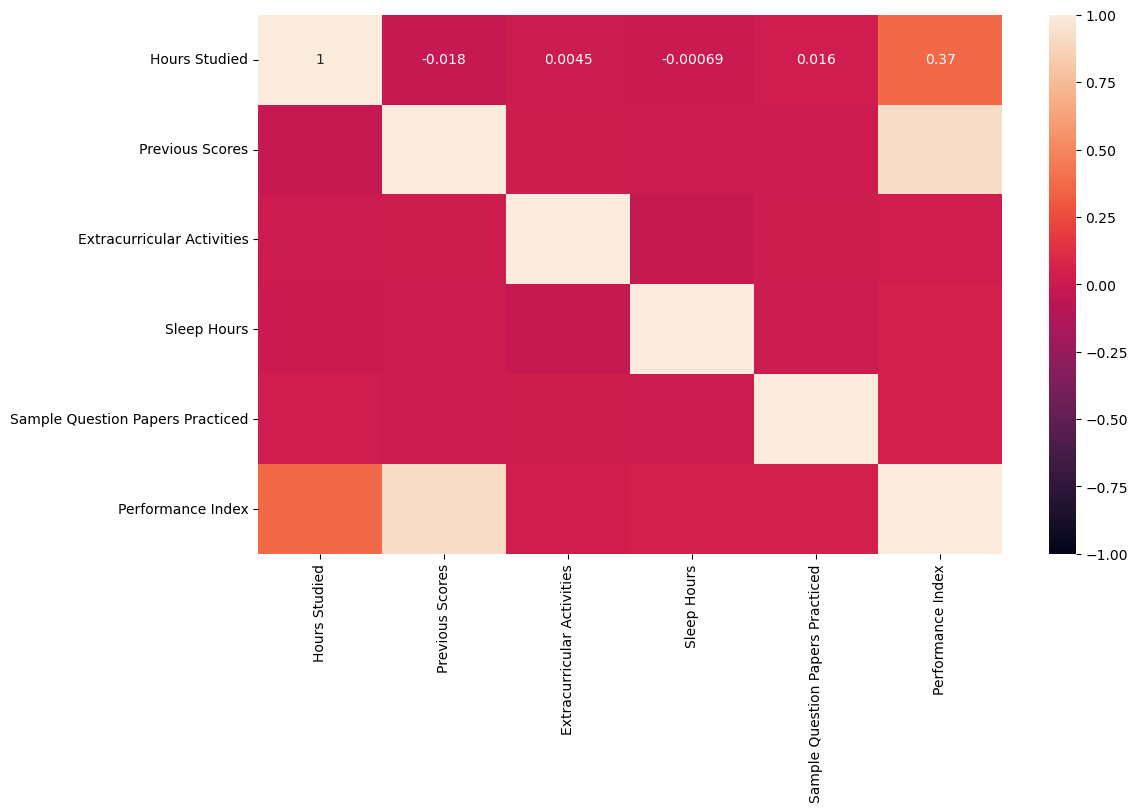

In [10]:
plt.figure(figsize = (12, 7))
sns.heatmap(train.corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

### Nhận xét
- Hours Studied và Previous Scores có mối tương quan dương khá mạnh, cho thấy cành học nhiều thì điểm số trước đó càng cao và ngược ngại. Điều này khá hợp lý trong thực tế vì việc học tập thường xuyên sẽ giúp cho ta nhớ lâu và giúp cải thiện kết quả.
- Các đặc trưng còn lại như Extracurricular Activities, Sample Question Papers Practiced, Sleep Hours có mối quan hệ rất yếu hoặc gần như không có mối quan hệ với Performance Index. Điều này cho thấy các yếu tố này không ảnh hưởng đáng kể đế thành tích học tập của sinh viên.

Do đó ta sẽ phân tích hai đặc trưng Hours Studied và Previous Scores kĩ hơn.

### Phân tích Hours Studied và Previous Scores

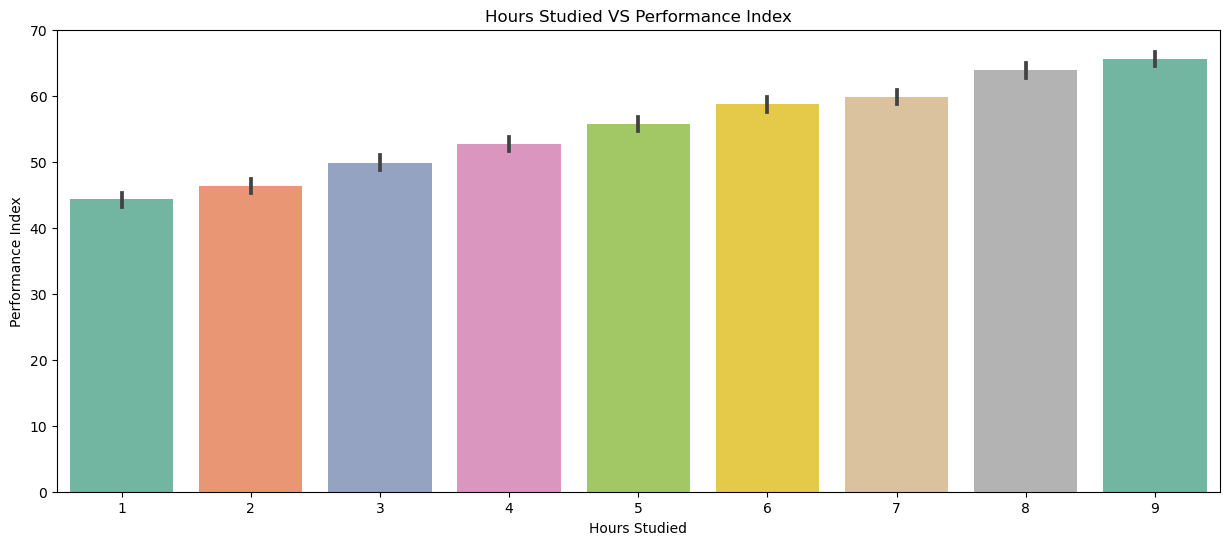

In [11]:
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Hours Studied', y = 'Performance Index', data = train, palette = 'Set2')

plt.title('Hours Studied VS Performance Index')
plt.show()

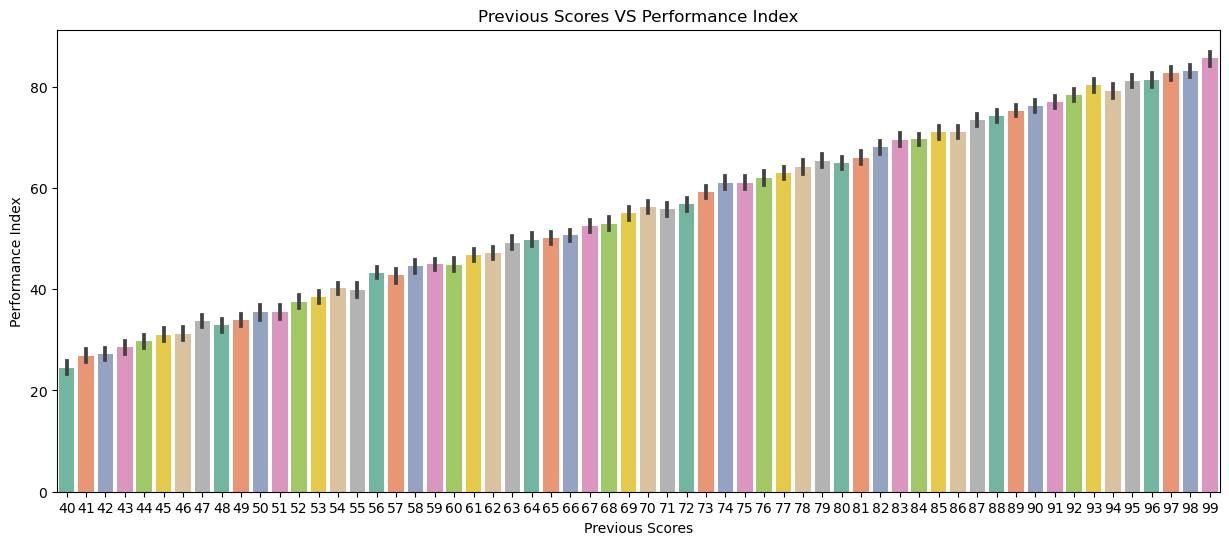

In [12]:
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Previous Scores', y = 'Performance Index', data = train, palette = 'Set2')

plt.title('Previous Scores VS Performance Index')
plt.show()

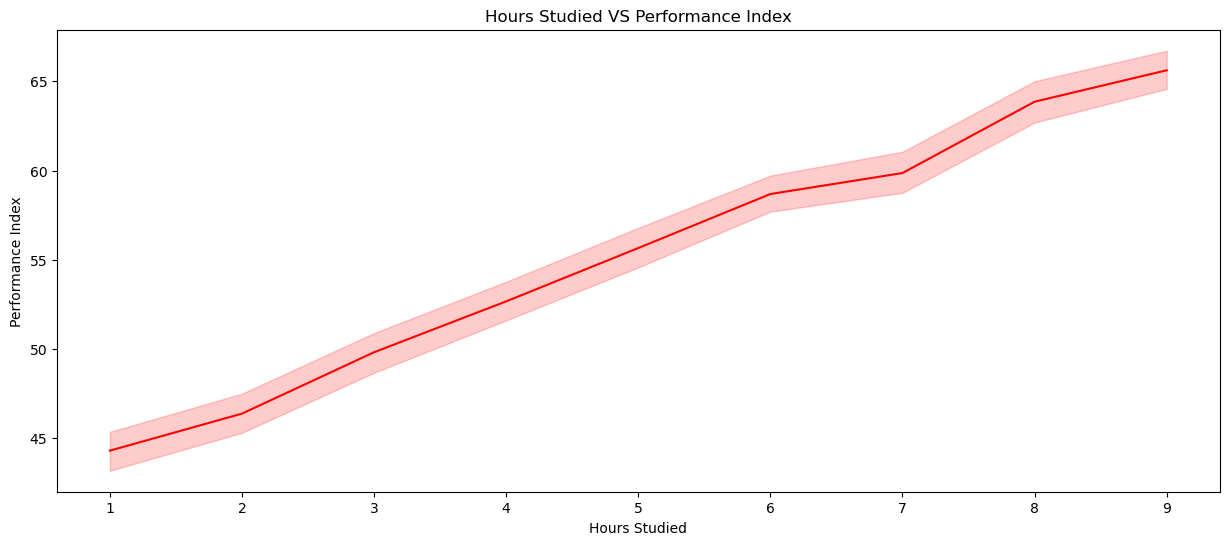

In [13]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = 'Hours Studied', y = 'Performance Index', data = train, color = 'red')

plt.title('Hours Studied VS Performance Index')
plt.show()

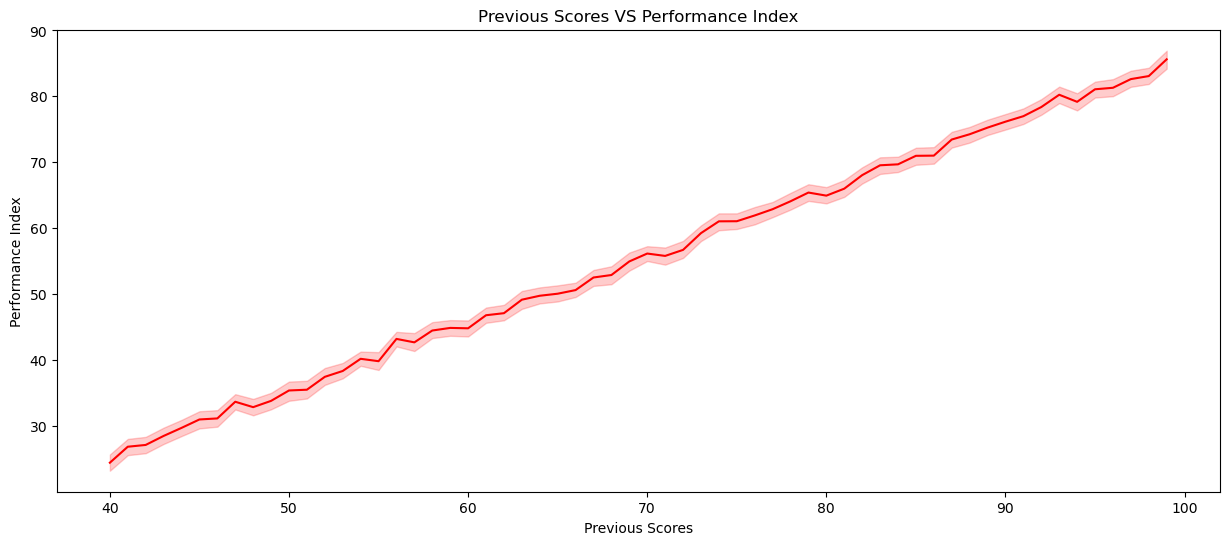

In [14]:
plt.figure(figsize = (15, 6))
sns.lineplot(x = 'Previous Scores', y = 'Performance Index', data = train, color = 'red')

plt.title('Previous Scores VS Performance Index')
plt.show()

# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp (2 điểm) 

In [15]:
# Phần code cho yêu cầu 2a
features_2a = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Questions Papers Practiced']

# Tiền xử lý dữ liệu cho 5 đặc trưng trên tập huấn luyện và tập kiểm tra
X_train_2a = preprocess(X_train, ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Questions Papers Practiced'])
y_train_2a = y_train
X_test_2a = preprocess(X_test, ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Questions Papers Practiced'])
y_test_2a = y_test

# Huấn luyện 1 lần duy nhất cho toàn bộ 5 đặc trưng trên tập huấn luyện (train.csv)
lr_2a = OLSLinearRegression().fit(X_train_2a, y_train_2a)

# In ra các trọng số tương ứng vừa huấn luyện được cho từng đặc trưng
params_2a = lr_2a.get_params()
print(f"Intercept term: {params_2a[0]}")
for i in range(1, len(params_2a)):
    print(f"{features_2a[i - 1]}: {params_2a[i]}")

# Tính giá trị dự đoán của tập kiểm tra dựa theo mô hình vừa có được
y_hat_2a = lr_2a.predict(X_test_2a)

Intercept term: -33.969283681727944
Hours Studied: 2.8520200719067246
Previous Scores: 1.0178695738370305
Extracurricular Activities: 0.6042817401213944
Sleep Hours: 0.47356583475097425
Sample Questions Papers Practiced: 0.19237624280136512


In [16]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
mae_2a = MAE(y_test_2a, y_hat_2a)
print("MAE: ", mae_2a)

MAE:  1.5956486884765246


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.969 + 2.852 \times \text{Hours Studied} + 1.018 \times \text{Previous Scores} + 0.604 \times \text{Extracurricular Activities} + 0.474 \times \text{Sleep Hours} + 0.192 \times \text{Sample Questions Papers Practiced}$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất (2 điểm)

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [17]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu
features_2b = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
models_2b = [['Hours Studied'], ['Previous Scores'], ['Extracurricular Activities'], ['Sleep Hours'], ['Sample Question Papers Practiced']]

# Thực hiện cross-validation
kfcv_2b = KFoldsCrossValidation(5, features_2b, models_2b, train)
kfcv_2b.shuffle_data()
kfcv_2b.split_to_k_folds()
kfcv_2b.cross_validation()
avg_mae_list, best_model_idx = kfcv_2b.best_model()

for i in range(len(avg_mae_list)):
    print(f"MAE trung bình cho mô hình với đặc trưng {features_2b[i]}: {avg_mae_list[i]}")
    
print(f"Mô hình tốt nhất là mô hình với đặc trưng: {features_2b[best_model_idx]}")

MAE trung bình cho mô hình với đặc trưng Hours Studied: 21.429857651403907
MAE trung bình cho mô hình với đặc trưng Previous Scores: 7.11217107398639
MAE trung bình cho mô hình với đặc trưng Extracurricular Activities: 35.693211951447246
MAE trung bình cho mô hình với đặc trưng Sleep Hours: 18.996130845044924
MAE trung bình cho mô hình với đặc trưng Sample Question Papers Practiced: 27.97482077945479
Mô hình tốt nhất là mô hình với đặc trưng: Previous Scores


In [18]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_train_2b = preprocess(train.loc[:, features_2b[best_model_idx]].to_numpy().reshape(-1, 1), [features_2b[best_model_idx]])
y_train_2b = y_train
X_test_2b = preprocess(test.loc[:, features_2b[best_model_idx]].to_numpy().reshape(-1, 1), [features_2b[best_model_idx]])
y_test_2b = y_test

# Huấn luyện 1 lần duy nhất cho toàn bộ 5 đặc trưng trên tập huấn luyện (train.csv)
lr_2b = OLSLinearRegression().fit(X_train_2b, y_train_2b)

# In ra các trọng số tương ứng vừa huấn luyện được cho từng đặc trưng
params_2b = lr_2b.get_params()
print(f"Intercept term: {params_2b[0]}")
print(f"{features_2b[best_model_idx]}: {params_2b[1]}")

# Tính giá trị dự đoán của tập kiểm tra dựa theo mô hình vừa có được
y_hat_2b = lr_2b.predict(X_test_2b)

Intercept term: -14.988645779316068
Previous Scores: 1.0105030093166387


In [19]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
mae_2b = MAE(y_test_2b, y_hat_2b)
print("MAE: ", mae_2b)

MAE:  6.54427729345265


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -14.989 + 1.011 \times \text{Previous Scores} $$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất (2 điểm)

## Xây dựng/Thiết kế mô hình

In [20]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình
model_2c_1 = ['Hours Studied', 'Previous Scores']
model_2c_2 = ['Hours Studied * Hours Studied', 'Previous Scores', 'Sample Question Papers Practiced']
model_2c_3 = ['Hours Studied', 'Previous Scores * Previous Scores', 'Sample Question Papers Practiced']

# Tiền xử lý dữ liệu cho 3 mô hình trên tập huấn luyện và tập kiểm tra
train_2c = train.copy()
train_2c['Hours Studied * Hours Studied'] = train_2c['Hours Studied'] * train_2c['Hours Studied']
train_2c['Previous Scores * Previous Scores'] = train_2c['Previous Scores'] * train_2c['Previous Scores']
train_2c = train_2c.drop(columns = ['Extracurricular Activities', 'Sleep Hours', 'Performance Index'], axis = 1)
train_2c['Performance Index'] = train['Performance Index']

test_2c = test.copy()
test_2c['Hours Studied * Hours Studied'] = test_2c['Hours Studied'] * test_2c['Hours Studied']
test_2c['Previous Scores * Previous Scores'] = test_2c['Previous Scores'] * test_2c['Previous Scores']
test_2c = test_2c.drop(columns = ['Extracurricular Activities', 'Sleep Hours', 'Performance Index'], axis = 1)
test_2c['Performance Index'] = test['Performance Index']

## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [21]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu
features_2c = ['Hours Studied', 'Previous Scores', 'Hours Studied + Previous Scores', 'Hours Studied * Previous Scores']
models_2c = [model_2c_1, model_2c_2, model_2c_3]

# Thực hiện cross-validation
kfcv_2c = KFoldsCrossValidation(5, features_2c, models_2c , train_2c)
kfcv_2c.shuffle_data()
kfcv_2c.split_to_k_folds()
kfcv_2c.cross_validation()

# In ra kết quả cross-validation
avg_mae_list, best_model_idx = kfcv_2c.best_model()
for i in range(len(avg_mae_list)):
    print(f"MAE trung bình cho mô hình thứ {i + 1}: {avg_mae_list[i]}")
print(f"Mô hình tốt nhất là mô hình thứ {best_model_idx + 1}")

MAE trung bình cho mô hình thứ 1: 5.679061864983116
MAE trung bình cho mô hình thứ 2: 4.99168478034849
MAE trung bình cho mô hình thứ 3: 2.4901415994773246
Mô hình tốt nhất là mô hình thứ 3


In [22]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
X_train_2c = preprocess(train_2c.loc[:, models_2c[best_model_idx]].to_numpy().reshape(-1, len(models_2c[best_model_idx])), models_2c[best_model_idx])
y_train_2c = train.iloc[:, -1]
X_test_2c = preprocess(test_2c.loc[:, models_2c[best_model_idx]].to_numpy().reshape(-1, len(models_2c[best_model_idx])), models_2c[best_model_idx])
y_test_2c = test.iloc[:, -1]

# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện  
lr_2c = OLSLinearRegression().fit(X_train_2c, y_train_2c)

# In ra các hệ số tương ứng vừa huấn luyện được cho từng feature
params_2c = lr_2c.get_params()
print(f"Intercept term: {params_2c[0]}")
for i in range(1, len(params_2c)):
    print(f"{models_2c[best_model_idx][i - 1]}: {params_2c[i]}")
    
# Tính giá trị dự đoán của tập kiểm tra dựa theo mô hình vừa có được
y_hat_2c = lr_2c.predict(X_test_2c)

Intercept term: 3.0115121308340598
Hours Studied: 2.8518750054993802
Previous Scores * Previous Scores: 0.007240430399352047
Sample Question Papers Practiced: 0.19161993294427915


In [23]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
mae_2c = MAE(y_test_2c, y_hat_2c)
print("MAE: ", mae_2c)

MAE:  2.425697043874505


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = 3.012 + 2.582 \times \text{Hours Studied} + 0.007 \times \text{(Previous Scores * Previous Scores)} + 0.192 \times \text{Sample Question Papers Practiced}$$